In [93]:
import h5py
from functools import cache, partial

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import pearsonr, spearmanr
from sklearn.metrics import r2_score
from tqdm.notebook import tqdm

In [91]:
GENE_CLASS_PATH = "../finetuning/data/h5_bins_384_chrom_split/gene_class.csv"
GEUVADIS_COUNTS_PATH = "../process_geuvadis_data/log_tpm/corrected_log_tpm.annot.csv.gz"
BASELINE_PREDS_PATH = "/data/yosef3/users/ruchir/personalized-expression-benchmark/predictions/enformer_sample_preds.csv"
METADATA_PATH = "/data/yosef3/users/ruchir/pgp_uq/data/E-GEUV-1.sdrf.txt"
MODEL_PREDS_PATH = "/data/yosef3/scratch/ruchir/finetuning-enformer/models/joint_training_classification_trial_A40x4_h5_dynamic_sampling_dataset_v2/test_preds.npz"
PREDIXCAN_PREDS_PATH = (
    "../predixcan_lite/h5_bins_384_chrom_split/predixcan_preds.384_bins.no_cv.csv"
)

In [31]:
def load_model_preds(path: str) -> pd.DataFrame:
    data = np.load(path)
    preds = data["preds"]
    genes = data["genes"]
    samples = data["samples"]

    unique_genes = sorted(np.unique(genes))
    unique_samples = sorted(np.unique(samples))
    gene_to_idx = {gene: idx for idx, gene in enumerate(unique_genes)}
    sample_to_idx = {sample: idx for idx, sample in enumerate(unique_samples)}

    preds_mtx = np.full((len(unique_genes), len(unique_samples)), np.nan)
    for (pred, gene, sample) in zip(preds, genes, samples):
        preds_mtx[gene_to_idx[gene], sample_to_idx[sample]] = pred
    return pd.DataFrame(preds_mtx, index=unique_genes, columns=unique_samples)


def check_sample_split_consistency(df1: pd.DataFrame, df2: pd.DataFrame):
    common_genes = df1.index.intersection(df2.index)
    for g in common_genes:
        df1_samples = df1.loc[g].dropna().index
        df2_samples = df2.loc[g].dropna().index
        assert set(df1_samples) == set(
            df2_samples
        ), f"Samples for gene {g} are not consistent"

In [83]:
predixcan_preds_df = pd.read_csv(PREDIXCAN_PREDS_PATH, index_col=0)
baseline_preds_df = pd.read_csv(BASELINE_PREDS_PATH, index_col=0).T
model_preds_df = load_model_preds(MODEL_PREDS_PATH)
check_sample_split_consistency(predixcan_preds_df, model_preds_df)

In [33]:
geuvadis_counts_df = pd.read_csv(GEUVADIS_COUNTS_PATH, index_col="our_gene_name")

# Correlation scatterplots

In [34]:
def compute_correlations(
    df1: pd.DataFrame, df2: pd.DataFrame, metric: str = "spearman"
) -> dict[str, float]:
    """
    For metric == r2_score, df1 should contain the true values and df2 the predictions.
    """
    common_genes = df1.index.intersection(df2.index)
    correlations = {}
    for g in tqdm(common_genes):
        df1_samples = df1.loc[g].dropna().index
        df2_samples = df2.loc[g].dropna().index
        common_samples = df1_samples.intersection(df2_samples)
        assert len(common_samples) == 77 or len(common_samples) == 421
        if metric == "spearman":
            corr, _ = spearmanr(df1.loc[g, common_samples], df2.loc[g, common_samples])
        elif metric == "pearson":
            corr, _ = pearsonr(df1.loc[g, common_samples], df2.loc[g, common_samples])
        elif metric == "r2_score":
            corr = r2_score(df1.loc[g, common_samples], df2.loc[g, common_samples])
        else:
            raise ValueError(f"Unknown metric {metric}")
        correlations[g] = corr if not np.isnan(corr) else 0.0
    return correlations

In [84]:
model_spearman_corrs = compute_correlations(
    geuvadis_counts_df, model_preds_df, metric="spearman"
)
model_pearson_corrs = compute_correlations(
    geuvadis_counts_df, model_preds_df, metric="pearson"
)

baseline_spearman_corrs = compute_correlations(
    geuvadis_counts_df, baseline_preds_df, metric="spearman"
)
baseline_pearson_corrs = compute_correlations(
    geuvadis_counts_df, baseline_preds_df, metric="pearson"
)

predixcan_spearman_corrs = compute_correlations(
    geuvadis_counts_df, predixcan_preds_df, metric="spearman"
)
predixcan_pearson_corrs = compute_correlations(
    geuvadis_counts_df, predixcan_preds_df, metric="pearson"
)

  0%|          | 0/500 [00:00<?, ?it/s]

/data/yosef3/scratch/ruchir/tools/mambaforge/envs/sc/lib/python3.10/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


  0%|          | 0/500 [00:00<?, ?it/s]

/data/yosef3/scratch/ruchir/tools/mambaforge/envs/sc/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


  0%|          | 0/3259 [00:00<?, ?it/s]

  0%|          | 0/3259 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

In [87]:
def compute_abs_corrs(corrs: dict[str, float]) -> dict[str, float]:
    return {g: abs(corr) for g, corr in corrs.items()}

In [72]:
def plot_correlation_comparison(
    corrs1: dict[str, float],
    corrs2: dict[str, float],
    ax: plt.Axes,
    xlabel: str,
    ylabel: str,
    title: str,
    genes: list[str] = None,
):
    if genes is None:
        genes = list(corrs1.keys() & corrs2.keys())
    else:
        assert set(genes).issubset(corrs1.keys() & corrs2.keys())

    corrs1_l = [corrs1[g] for g in genes]
    corrs2_l = [corrs2[g] for g in genes]
    sns.scatterplot(x=corrs1_l, y=corrs2_l, ax=ax)
    ax.set_xlabel(xlabel + "\n" + rf"$\mu$ = {np.mean(corrs1_l):.3f}")
    ax.set_ylabel(ylabel + "\n" + rf" $\mu$ = {np.mean(corrs2_l):.3f}")
    ax.set_title(title)

    # Draw y = x line
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),
        np.max([ax.get_xlim(), ax.get_ylim()]),
    ]
    ax.plot(lims, lims, "k-", alpha=0.75, zorder=0)
    ax.set_aspect("equal")
    ax.set_xlim(lims)
    ax.set_ylim(lims)

    # Add text for number of genes where corrs1 > corrs2 and vice versa
    n_corrs1_better = sum(c1 > c2 for c1, c2 in zip(corrs1_l, corrs2_l))
    n_corrs2_better = sum(c1 < c2 for c1, c2 in zip(corrs1_l, corrs2_l))
    ax.text(
        0.83, 0.05, f"{n_corrs1_better}/{len(genes)}", transform=ax.transAxes, c="r"
    )
    ax.text(
        0.05, 0.95, f"{n_corrs2_better}/{len(genes)}", transform=ax.transAxes, c="r"
    )

In [43]:
gene_class_df = pd.read_csv(GENE_CLASS_PATH, index_col=0)
random_split_genes = gene_class_df[gene_class_df["class"] == "random_split"].index
yri_split_genes = gene_class_df[gene_class_df["class"] == "yri_split"].index
unseen_genes = gene_class_df[gene_class_df["class"] == "unseen"].index

### Spearman (finetuned v PrediXcan)

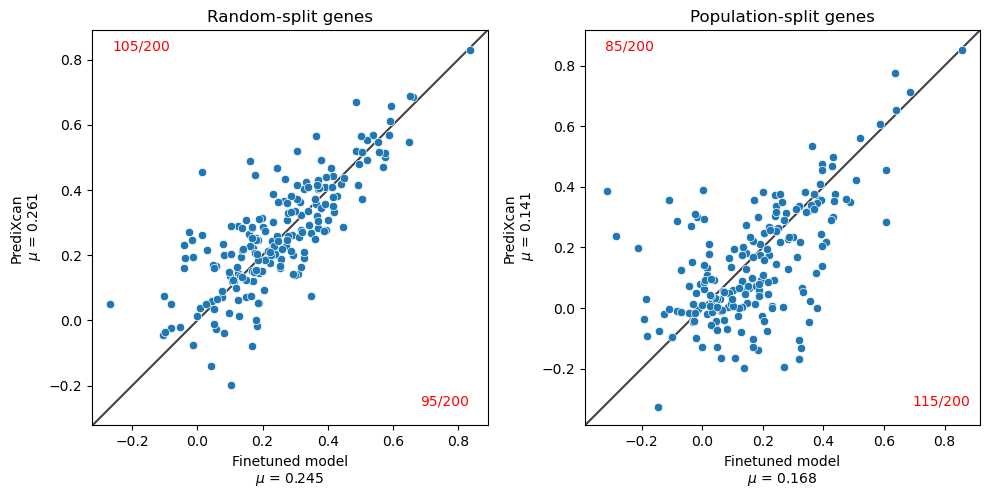

In [73]:
fig, axs = plt.subplots(ncols=2, figsize=(10, 5))

plot_correlation_comparison(
    model_spearman_corrs,
    predixcan_spearman_corrs,
    axs[0],
    xlabel="Finetuned model",
    ylabel="PrediXcan",
    title="Random-split genes",
    genes=random_split_genes,
)

plot_correlation_comparison(
    model_spearman_corrs,
    predixcan_spearman_corrs,
    axs[1],
    xlabel="Finetuned model",
    ylabel="PrediXcan",
    title="Population-split genes",
    genes=yri_split_genes,
)

plt.tight_layout()
plt.show()

### Pearson (finetuned v PrediXcan)

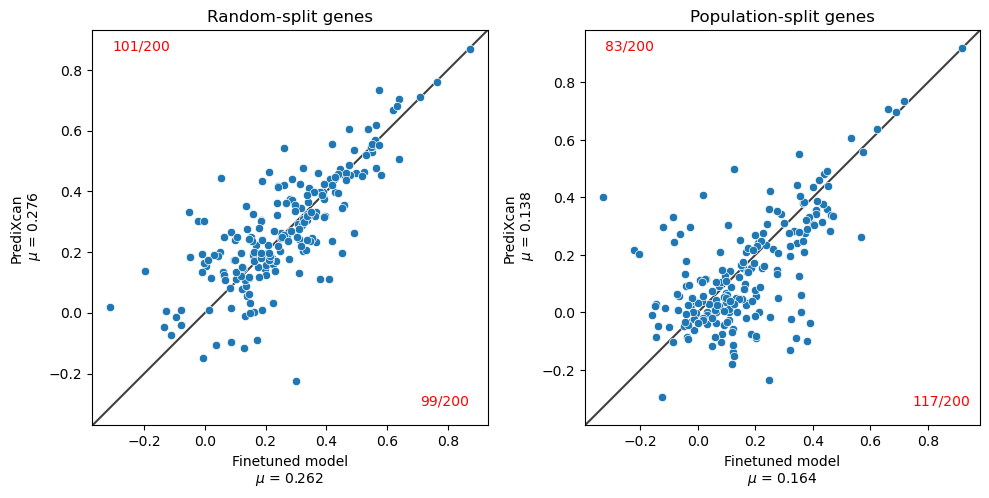

In [74]:
fig, axs = plt.subplots(ncols=2, figsize=(10, 5))

plot_correlation_comparison(
    model_pearson_corrs,
    predixcan_pearson_corrs,
    axs[0],
    xlabel="Finetuned model",
    ylabel="PrediXcan",
    title="Random-split genes",
    genes=random_split_genes,
)

plot_correlation_comparison(
    model_pearson_corrs,
    predixcan_pearson_corrs,
    axs[1],
    xlabel="Finetuned model",
    ylabel="PrediXcan",
    title="Population-split genes",
    genes=yri_split_genes,
)

plt.tight_layout()
plt.show()

### Unseen (finetuned v baseline)

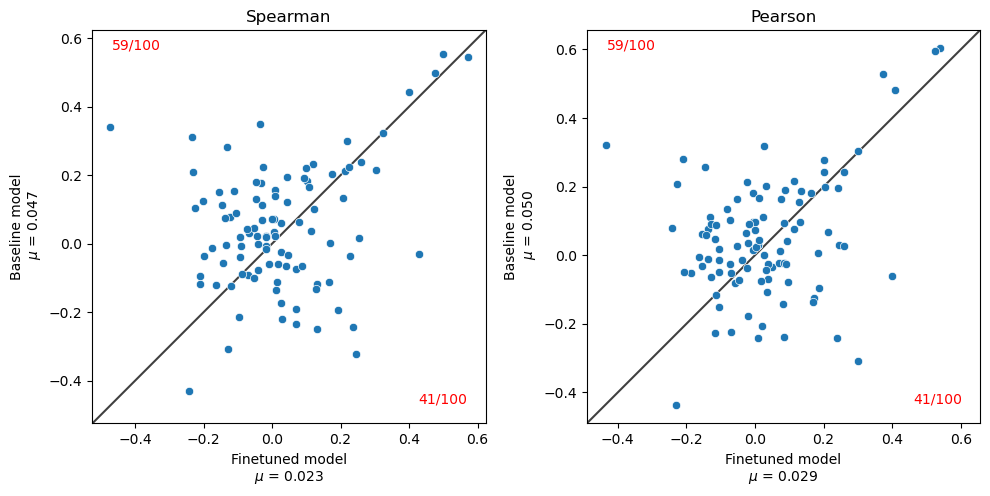

In [86]:
fig, axs = plt.subplots(ncols=2, figsize=(10, 5))

plot_correlation_comparison(
    model_spearman_corrs,
    baseline_spearman_corrs,
    axs[0],
    xlabel="Finetuned model",
    ylabel="Baseline model",
    title="Spearman",
    genes=unseen_genes,
)

plot_correlation_comparison(
    model_pearson_corrs,
    baseline_pearson_corrs,
    axs[1],
    xlabel="Finetuned model",
    ylabel="Baseline model",
    title="Pearson",
    genes=unseen_genes,
)

plt.tight_layout()
plt.show()

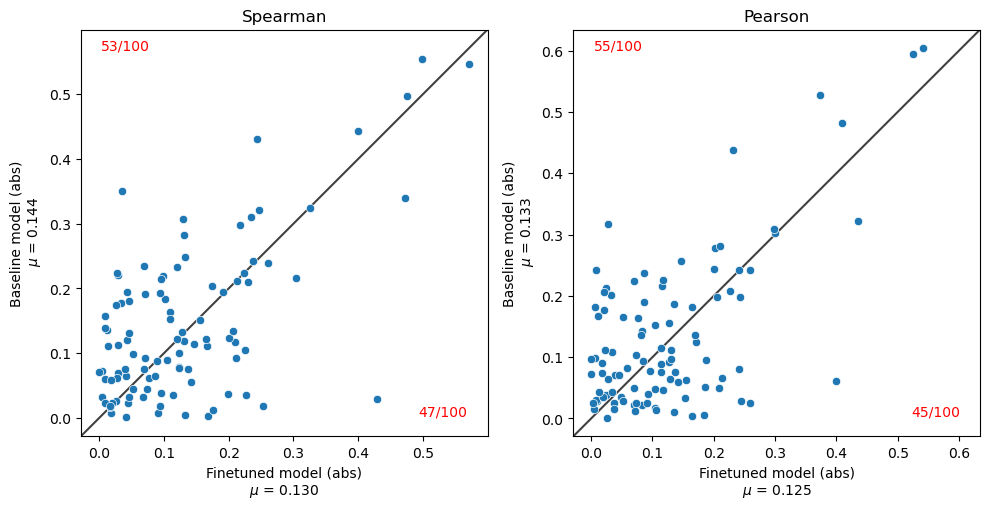

In [88]:
fig, axs = plt.subplots(ncols=2, figsize=(10, 5))

plot_correlation_comparison(
    compute_abs_corrs(model_spearman_corrs),
    compute_abs_corrs(baseline_spearman_corrs),
    axs[0],
    xlabel="Finetuned model (abs)",
    ylabel="Baseline model (abs)",
    title="Spearman",
    genes=unseen_genes,
)

plot_correlation_comparison(
    compute_abs_corrs(model_pearson_corrs),
    compute_abs_corrs(baseline_pearson_corrs),
    axs[1],
    xlabel="Finetuned model (abs)",
    ylabel="Baseline model (abs)",
    title="Pearson",
    genes=unseen_genes,
)

plt.tight_layout()
plt.show()

# Single-gene scatterplots

In [112]:
@cache
def get_sample_ancestries() -> dict[str, str]:
    df = pd.read_csv(METADATA_PATH, sep="\t", header=0, index_col=0)
    return df["Characteristics[ancestry category]"].to_dict()


def plot_correlation_comparison(
    df1: pd.DataFrame,
    df2: pd.DataFrame,
    gene: str,
    ax: plt.Axes,
    xlabel: str,
    ylabel: str,
    samples: list[str] = None,
):
    if samples is None:
        df1_samples = df1.loc[gene].dropna().index
        df2_samples = df2.loc[gene].dropna().index
        samples = df1_samples.intersection(df2_samples)
    else:
        assert set(samples).issubset(
            df1.loc[gene].index.intersection(df2.loc[gene].index)
        )

    df1_preds = df1.loc[gene, samples]
    df2_preds = df2.loc[gene, samples]
    spearman, _ = spearmanr(df1_preds, df2_preds)
    pearson, _ = pearsonr(df1_preds, df2_preds)

    ancestries = get_sample_ancestries()
    sample_ancestries = [ancestries[s] for s in samples]

    sns.scatterplot(x=df1_preds, y=df2_preds, hue=sample_ancestries, ax=ax)
    ax.set(xlabel=xlabel, ylabel=ylabel)
    ax.set_title(f"{gene} (Spearman: {spearman:.3f}, Pearson: {pearson:.3f})")

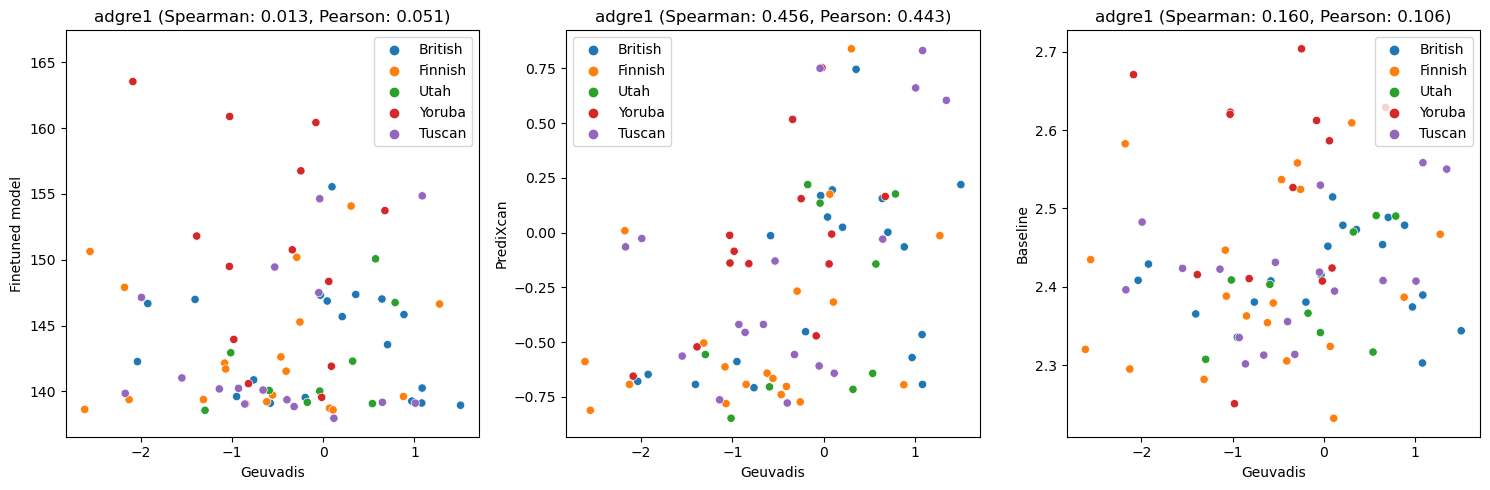

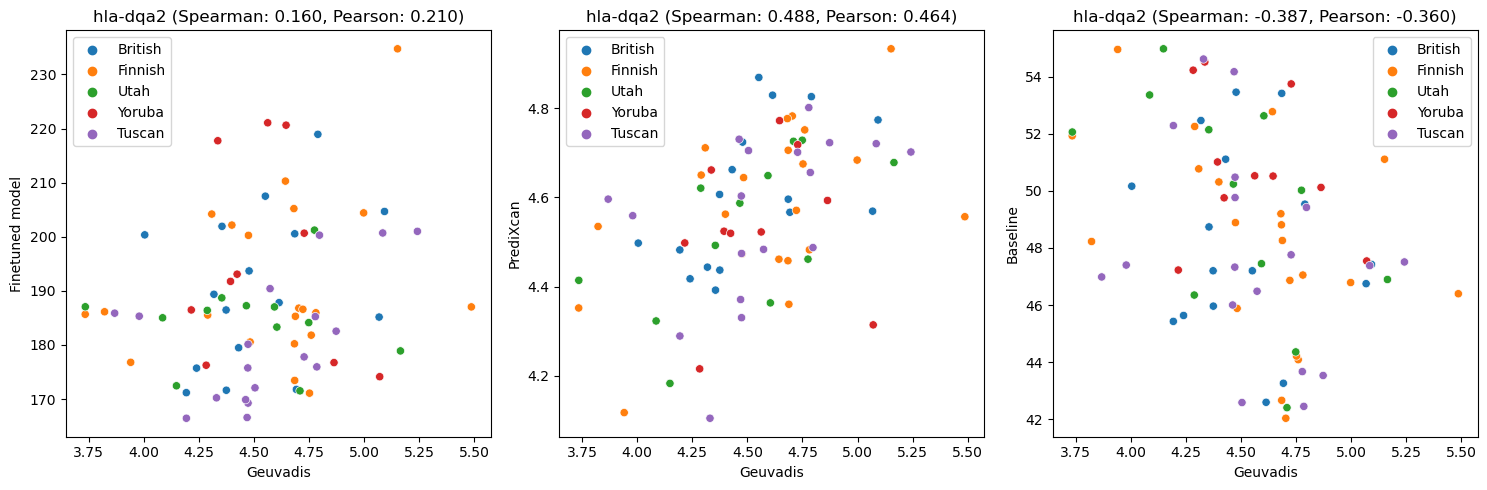

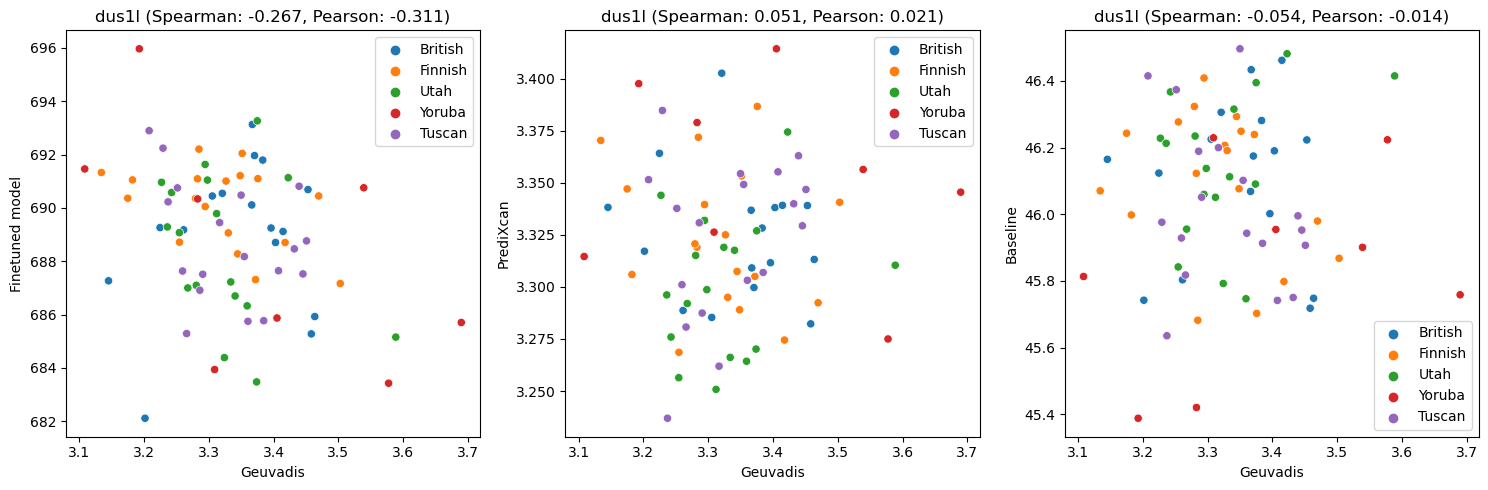

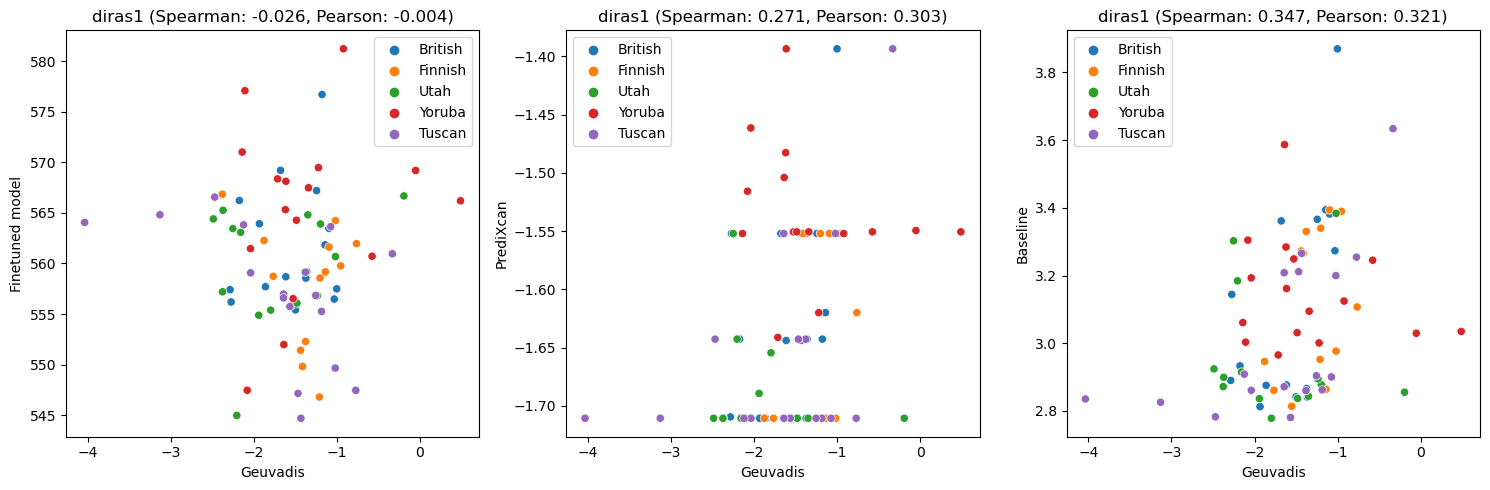

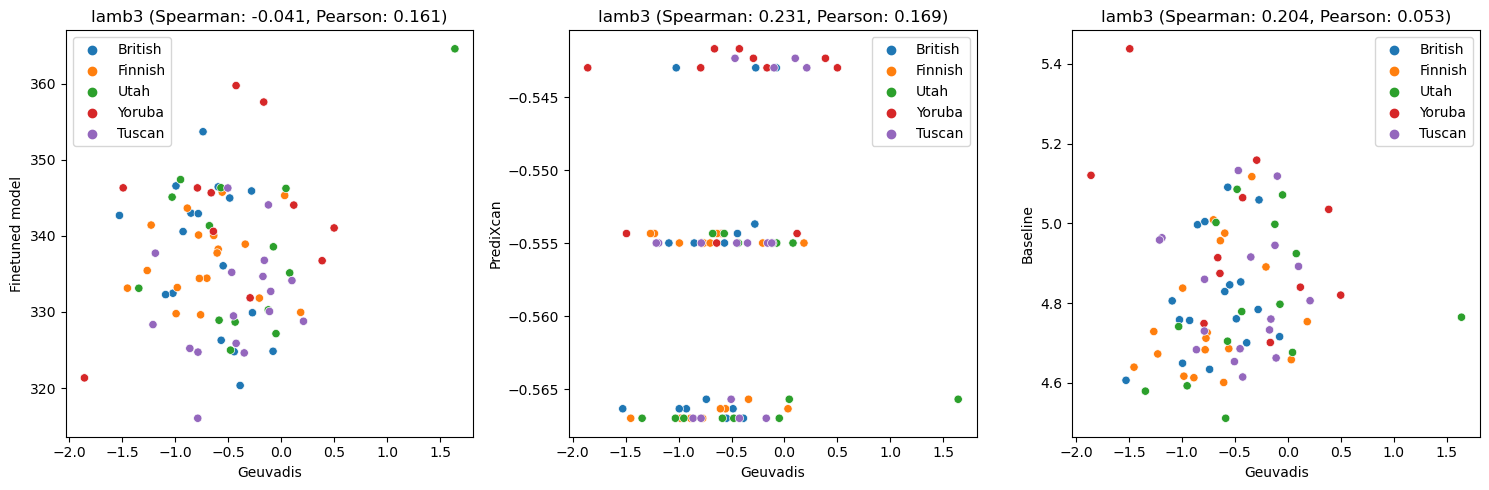

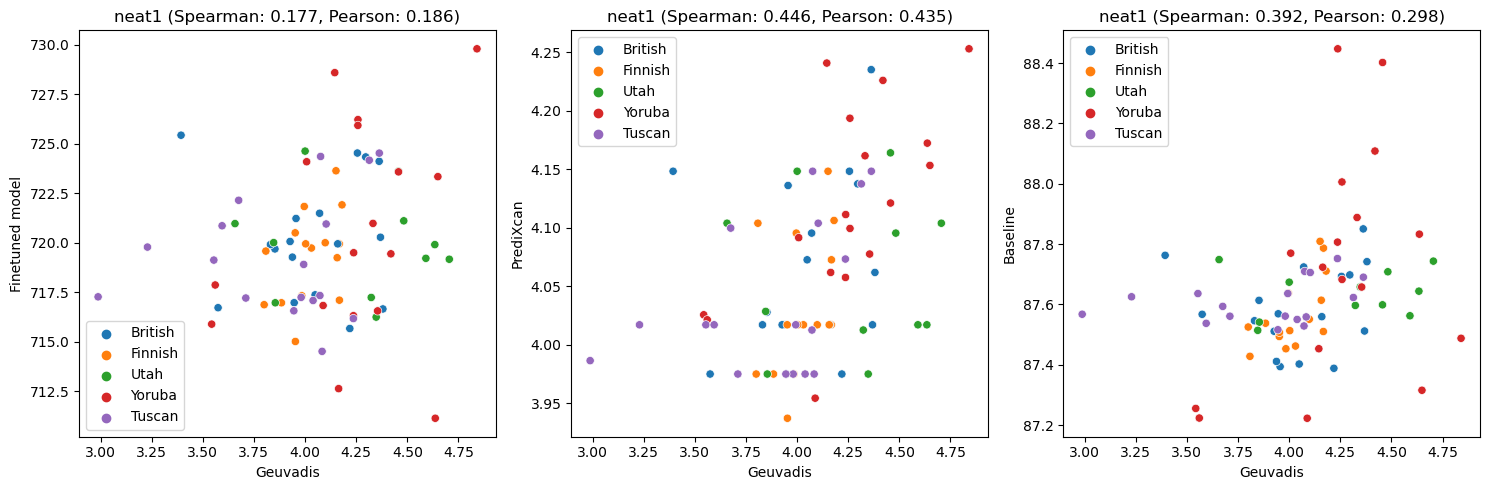

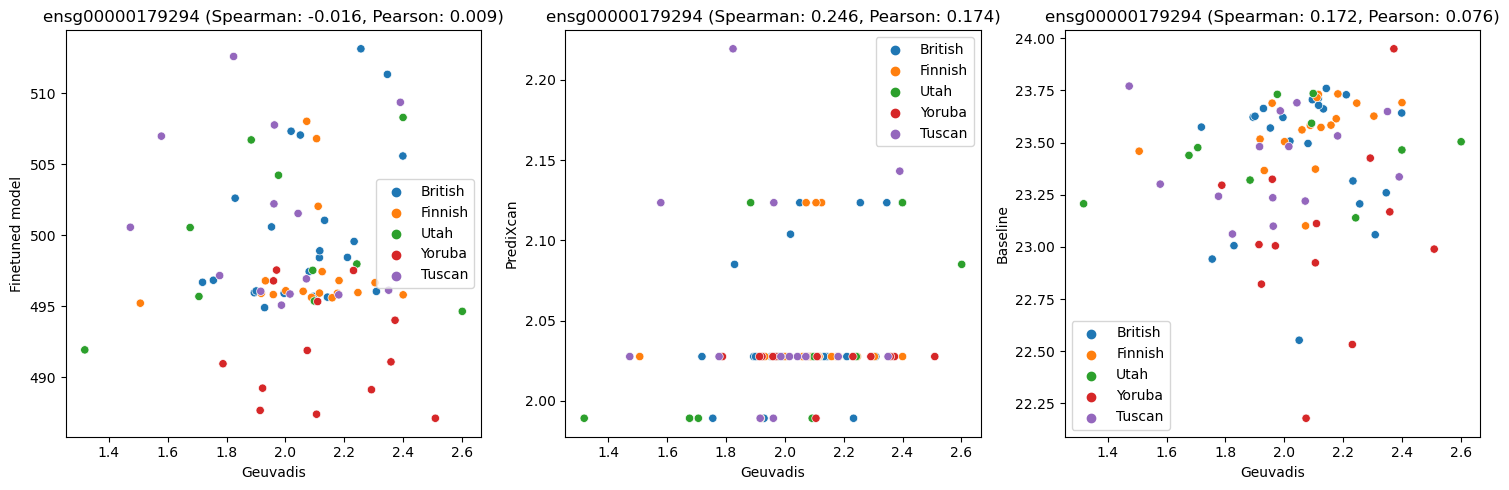

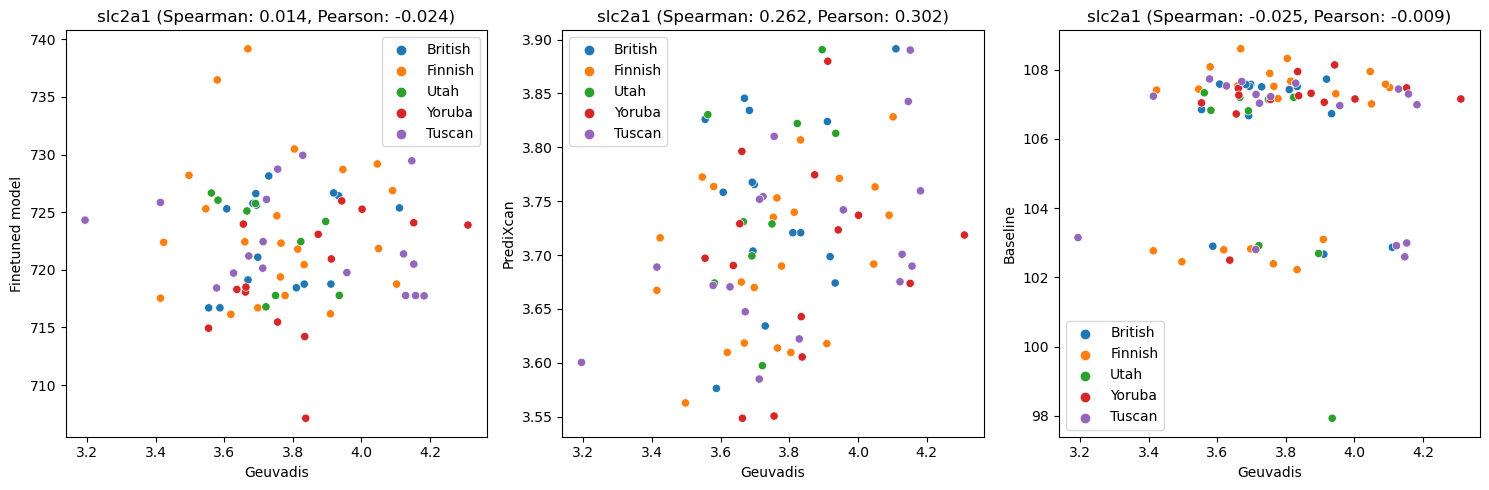

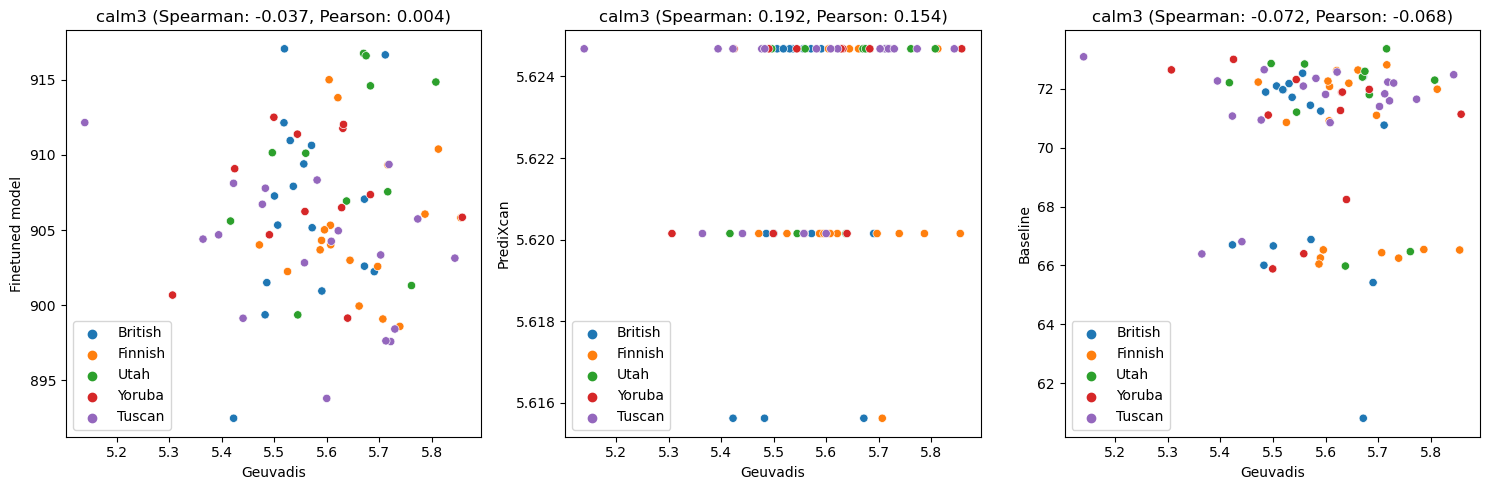

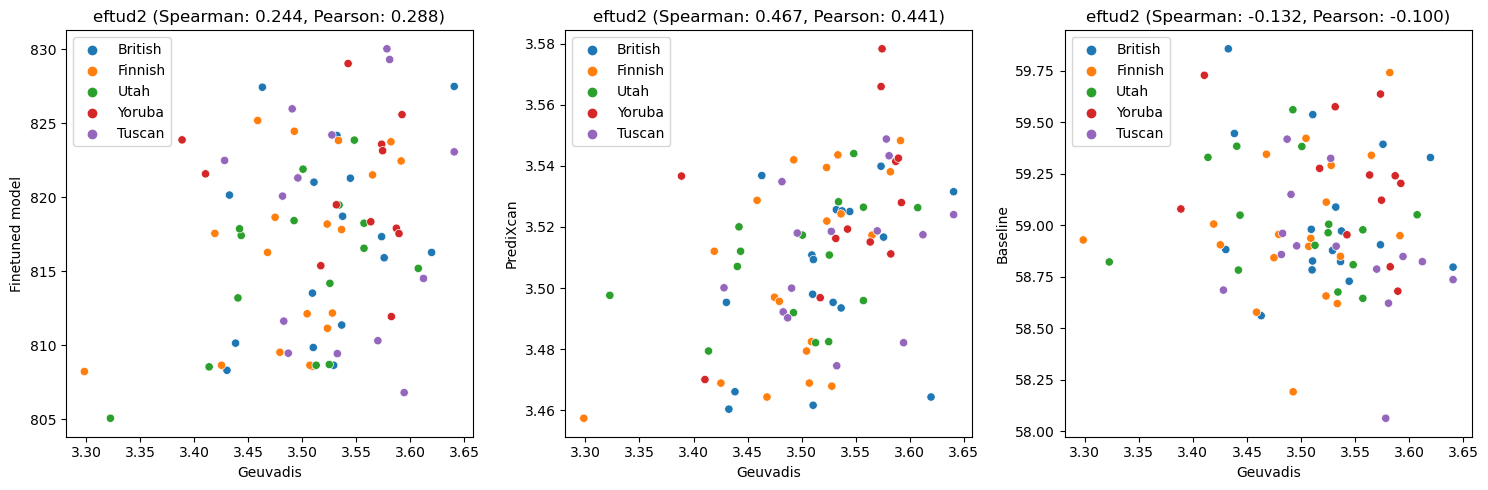

In [115]:
# Find random_split genes where prediXcan does much better than the finetuned model
random_split_diffs = {
    g: predixcan_spearman_corrs[g] - model_spearman_corrs[g] for g in random_split_genes
}
for g in sorted(random_split_diffs, key=random_split_diffs.get, reverse=True)[:10]:
    fig, axs = plt.subplots(ncols=3, figsize=(15, 5))
    plot_correlation_comparison(
        geuvadis_counts_df,
        model_preds_df,
        g,
        axs[0],
        "Geuvadis",
        "Finetuned model",
    )

    plot_correlation_comparison(
        geuvadis_counts_df,
        predixcan_preds_df,
        g,
        axs[1],
        "Geuvadis",
        "PrediXcan",
    )

    plot_correlation_comparison(
        geuvadis_counts_df,
        baseline_preds_df,
        g,
        axs[2],
        "Geuvadis",
        "Baseline",
        samples=model_preds_df.loc[g].dropna().index.tolist(),
    )

    plt.tight_layout()
    plt.show()

# Compare cross-gene performance

In [161]:
def compare_cross_gene_perf(
    geuvadis_counts_df: pd.DataFrame,
    model_preds_df: pd.DataFrame,
    baseline_preds_df: pd.DataFrame,
    title: str,
    genes: list[str] = None,
):
    if genes is None:
        genes = list(model_preds_df.index.intersection(baseline_preds_df.index))
    else:
        assert set(genes).issubset(
            set(model_preds_df.index) & set(baseline_preds_df.index)
        )

    mean_model_preds = []
    mean_baseline_preds = []
    mean_geuvadis_counts = []
    for g in genes:
        samples = model_preds_df.loc[g].dropna().index
        assert len(samples) == 77 or len(samples) == 421
        mean_model_preds.append(model_preds_df.loc[g, samples].mean())
        mean_baseline_preds.append(baseline_preds_df.loc[g, samples].mean())
        mean_geuvadis_counts.append(geuvadis_counts_df.loc[g, samples].mean())

    model_spearman = spearmanr(mean_geuvadis_counts, mean_model_preds)[0]
    baseline_spearman = spearmanr(mean_geuvadis_counts, mean_baseline_preds)[0]

    model_pearson = pearsonr(mean_geuvadis_counts, mean_model_preds)[0]
    baseline_pearson = pearsonr(mean_geuvadis_counts, mean_baseline_preds)[0]

    fig, axs = plt.subplots(ncols=2, figsize=(10, 5))
    sns.scatterplot(x=mean_geuvadis_counts, y=mean_model_preds, ax=axs[0])
    axs[0].set(xlabel="Geuvadis counts", ylabel="Finetuned model preds")
    axs[0].set_title(
        f"Finetuned model (Spearman: {model_spearman:.3f}, Pearson: {model_pearson:.3f})"
    )

    sns.scatterplot(x=mean_geuvadis_counts, y=mean_baseline_preds, ax=axs[1])
    axs[1].set(xlabel="Geuvadis counts", ylabel="Baseline preds")
    axs[1].set_title(
        f"Baseline model (Spearman: {baseline_spearman:.3f}, Pearson: {baseline_pearson:.3f})"
    )

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

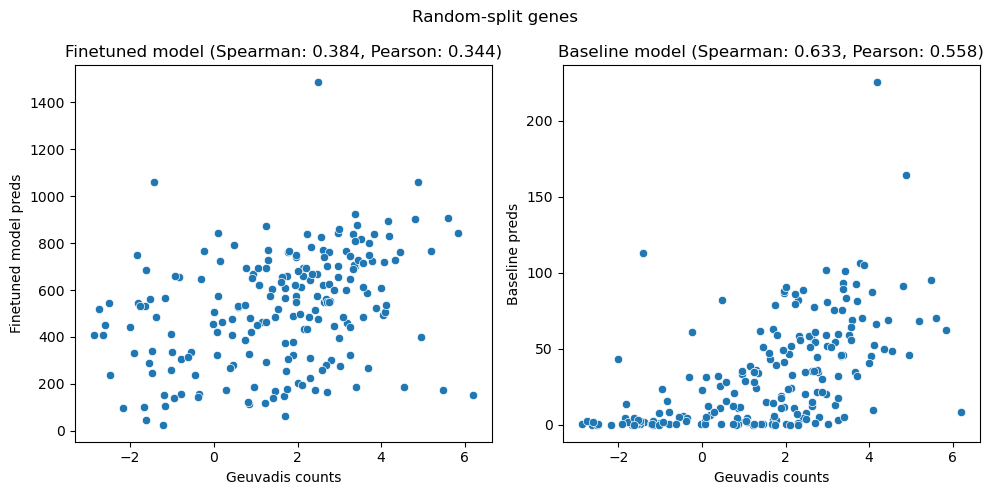

In [162]:
compare_cross_gene_perf(
    geuvadis_counts_df,
    model_preds_df,
    baseline_preds_df,
    "Random-split genes",
    genes=random_split_genes,
)

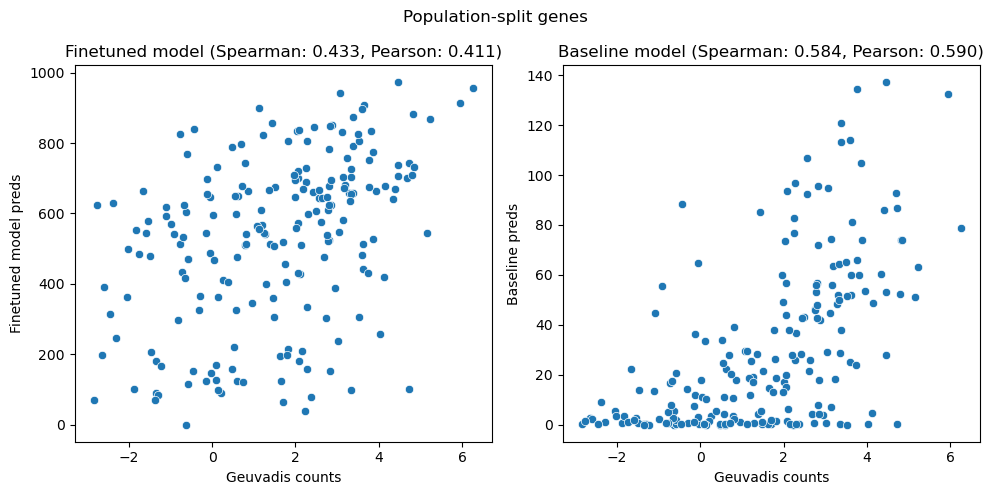

In [163]:
compare_cross_gene_perf(
    geuvadis_counts_df,
    model_preds_df,
    baseline_preds_df,
    "Population-split genes",
    genes=yri_split_genes,
)

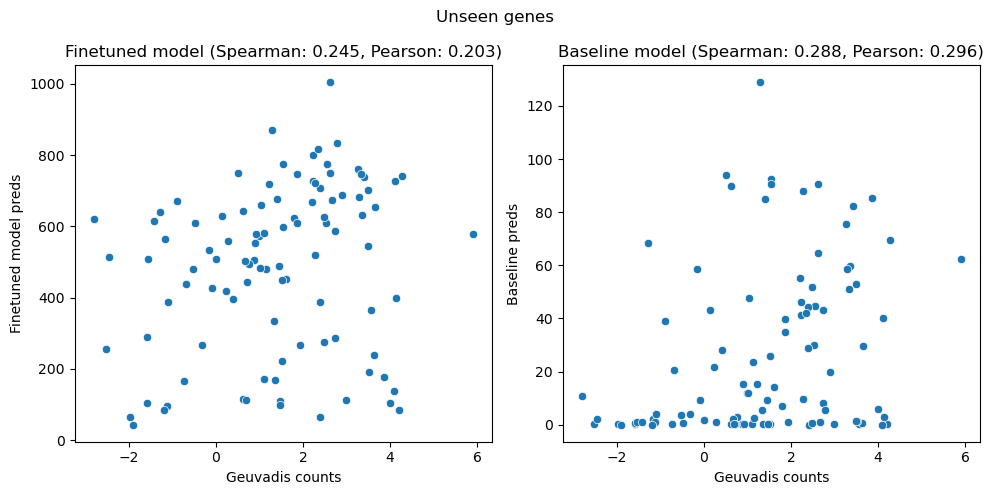

In [164]:
compare_cross_gene_perf(
    geuvadis_counts_df,
    model_preds_df,
    baseline_preds_df,
    "Unseen genes",
    genes=unseen_genes,
)